# Notebook Title

## Setup Python and R environment
you can ignore this section

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


## Load & Clean Data

👉 Load the data along with the census connectors below (the output of the `connect-to-census.ipynb` notebook) and do any cleanup you'd like to do.

In [4]:
%%R -o data
# Load the data
data <- read.csv('fireworks-14to24.csv')
# print column name
print(colnames(data))

 [1] "Unique.Key"                     "Created.Date"                  
 [3] "Closed.Date"                    "Agency"                        
 [5] "Agency.Name"                    "Complaint.Type"                
 [7] "Descriptor"                     "Location.Type"                 
 [9] "Incident.Zip"                   "Incident.Address"              
[11] "Street.Name"                    "Cross.Street.1"                
[13] "Cross.Street.2"                 "Intersection.Street.1"         
[15] "Intersection.Street.2"          "Address.Type"                  
[17] "City"                           "Landmark"                      
[19] "Facility.Type"                  "Status"                        
[21] "Due.Date"                       "Resolution.Action.Updated.Date"
[23] "Community.Board"                "Borough"                       
[25] "X.Coordinate..State.Plane."     "Y.Coordinate..State.Plane."    
[27] "Park.Facility.Name"             "Park.Borough"                  
[29] "

In [5]:
import pandas as pd
data = data[["Created.Date", "Duration","Incident.Zip", "Incident.Address", "Address.Type"]]

## 👉 Grab Census Data

1. loading the Census API key

In [5]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()


True

In [6]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("CENSUS_API_KEY"))

Loading required package: tidycensus
To install your API key for use in future sessions, run this function with `install = TRUE`.


2. Decide which Census variables you want

    Use <https://censusreporter.org/> to figure out which tables you want. (if censusreporter is down, check out the code in the cell below)

    -   Scroll to the bottom of the page to see the tables.
    -   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

    By default this code loads (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

    - find some other variables that you're also interested in
    - don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
    ).


In [8]:
%%R 

# Finding the Census Varaibles for the ACS 5 year survey
# Generall you'd do this in CensusReporter, but since it's down sometimes, here it is using tidycensus's load_variables function

# get every single variable in the ACS5
all_census_vars <- load_variables(2022, "acs5", cache = TRUE) 

filtered_census_vars <- all_census_vars %>% 
    filter(grepl("population", label, ignore.case = TRUE))   # filter to those containing "median income"
    
# write to CSV so we can view it in python
filtered_census_vars %>% 
    write_csv("filtered_census_vars.csv")

# show the first few rows
filtered_census_vars %>%
    select(-geography) %>% # remove the geography column
    print(n = 20) # print the first 20 rows

# A tibble: 1,877 × 3
   name       label                                                      concept
   <chr>      <chr>                                                      <chr>  
 1 B16008_002 "Estimate!!Total:!!Native population:"                     Citize…
 2 B16008_003 "Estimate!!Total:!!Native population:!!5 to 17 years:"     Citize…
 3 B16008_004 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 4 B16008_005 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 5 B16008_006 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 6 B16008_007 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 7 B16008_008 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 8 B16008_009 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
 9 B16008_010 "Estimate!!Total:!!Native population:!!5 to 17 years:!!Sp… Citize…
10 B16008_011 "Estimate!!Total:!!Native population:!!18 years and over:" Citize…
11 B16

In [7]:
%%R 
# the variable B01003_001E was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# in the table below, pick the geography, the variables, and the survey you want to pull from
# see the possible values here https://walker-data.com/tidycensus/articles/basic-usage.html

# Get variable from ACS, geography = zip code tabulation area
nyc_census_data <- get_acs(geography = "zip code tabulation area", 
                      variables = c(
                        population="B01003_001",
                        total_units = "B25001_001",
                        med_inc="B19013_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)


  |======================================================================| 100%


Getting data from the 2017-2021 5-year ACS


In [8]:
%%R
write_csv(nyc_census_data, "nyc_census_data.csv")

Exception ignored from cffi callback <function _processevents at 0x1071ebba0>:
Traceback (most recent call last):
  File "/Users/apple/.pyenv/versions/3.11.6/lib/python3.11/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


In [10]:
%%R
# read zip.csv
zip <- read.csv('zip.csv')
# Incident Zip type change to character
zip$Incident.Zip <- as.character(zip$Incident.Zip)

In [11]:
%%R
head(nyc_census_data)

Simple feature collection with 6 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -80.3686 ymin: 40.04419 xmax: -79.05512 ymax: 40.35755
Geodetic CRS:  NAD83
  GEOID        NAME    variable estimate  moe                       geometry
1 15301 ZCTA5 15301  population    49802  788 MULTIPOLYGON (((-80.3686 40...
2 15301 ZCTA5 15301 total_units    23303  563 MULTIPOLYGON (((-80.3686 40...
3 15301 ZCTA5 15301     med_inc    62902 3704 MULTIPOLYGON (((-80.3686 40...
4 15658 ZCTA5 15658  population     8315  397 MULTIPOLYGON (((-79.34323 4...
5 15658 ZCTA5 15658 total_units     4706  268 MULTIPOLYGON (((-79.34323 4...
6 15658 ZCTA5 15658     med_inc    70079 6638 MULTIPOLYGON (((-79.34323 4...


In [12]:
%%R
nyc_census_data <- nyc_census_data %>% 
  filter(GEOID %in% zip$Incident.Zip)
  
nyc_census_data

Simple feature collection with 504 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.6513 ymax: 40.91528
Geodetic CRS:  NAD83
First 10 features:
   GEOID        NAME    variable estimate  moe                       geometry
1  10037 ZCTA5 10037  population    19374 1339 MULTIPOLYGON (((-73.94317 4...
2  10037 ZCTA5 10037 total_units    11150  589 MULTIPOLYGON (((-73.94317 4...
3  10037 ZCTA5 10037     med_inc    48782 8464 MULTIPOLYGON (((-73.94317 4...
4  11414 ZCTA5 11414  population    30915 2621 MULTIPOLYGON (((-73.86317 4...
5  11414 ZCTA5 11414 total_units    12145  744 MULTIPOLYGON (((-73.86317 4...
6  11414 ZCTA5 11414     med_inc    86113 9709 MULTIPOLYGON (((-73.86317 4...
7  10473 ZCTA5 10473  population    60296 2711 MULTIPOLYGON (((-73.88441 4...
8  10473 ZCTA5 10473 total_units    23068  917 MULTIPOLYGON (((-73.88441 4...
9  10473 ZCTA5 10473     med_inc    48212 4600 MULTIPOLYGON (((-73.88441 4...
10

## 👉 Merge it with your data

hint...`tidycensus` provides you data in long format you may need to pivot the census data from long to wide format before merging it with your data

In [13]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 168 features and 8 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.6513 ymax: 40.91528
Geodetic CRS:  NAD83
# A tibble: 168 × 9
   GEOID NAME                                       geometry population_estimate
   <chr> <chr>                            <MULTIPOLYGON [°]>               <dbl>
 1 10037 ZCTA5 10037 (((-73.94317 40.81094, -73.94225 40.81…               19374
 2 11414 ZCTA5 11414 (((-73.86317 40.65828, -73.86036 40.65…               30915
 3 10473 ZCTA5 10473 (((-73.88441 40.82297, -73.87993 40.82…               60296
 4 10036 ZCTA5 10036 (((-74.00377 40.76356, -74.00135 40.76…               30437
 5 11355 ZCTA5 11355 (((-73.83792 40.75454, -73.8338 40.756…               80918
 6 11421 ZCTA5 11421 (((-73.86931 40.69935, -73.86916 40.70…               42704
 7 10308 ZCTA5 10308 (((-74.16499 40.56145, -74.16444 40.56…               30353
 8 10039 ZCTA5 10039 (((-73.94384 40.82365, -73.9429

In [22]:
%%R
# save nyc_census_data to csv
write_csv(nyc_census_data, "nyc_census_data.csv")

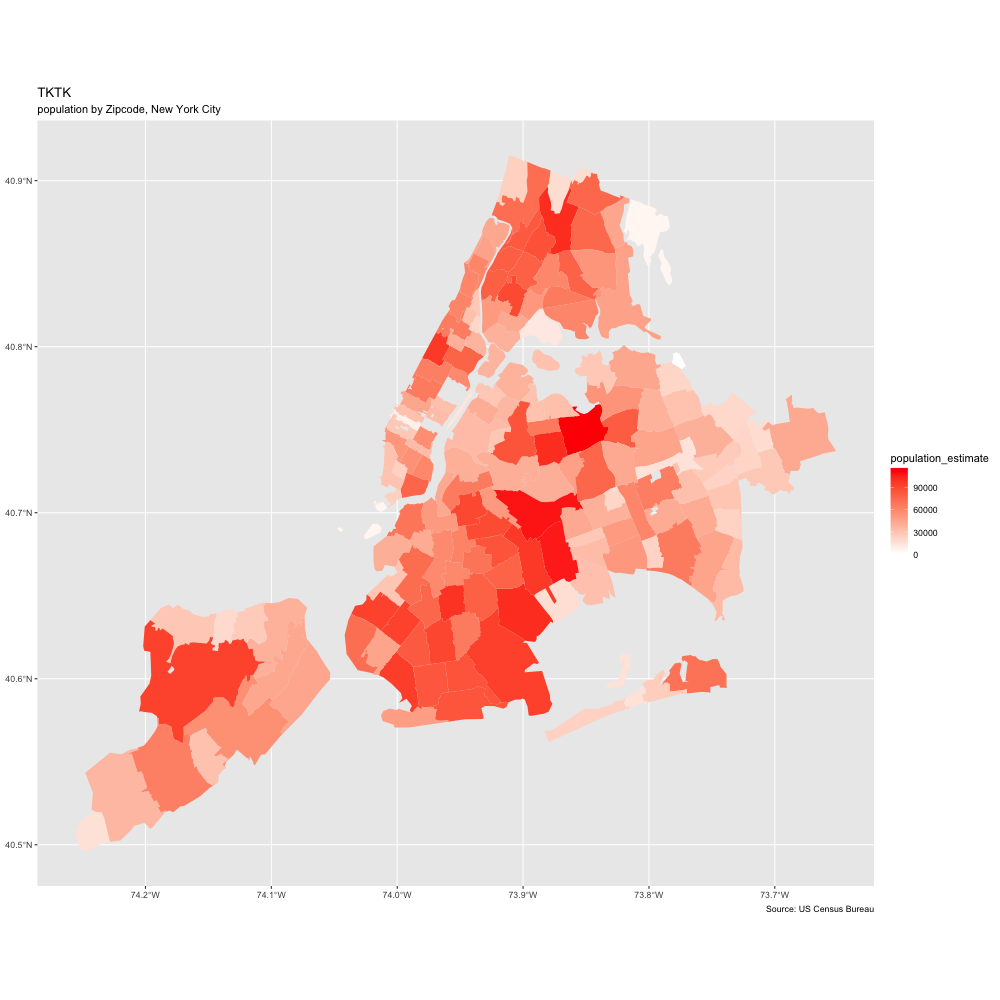

In [23]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = population_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "population by Zipcode, New York City",
    caption = "Source: US Census Bureau"
  )

In [16]:
%%R
# merge the data by "Incident.Zip" with nyc_census_data by "GEOID"
merged <- zip %>% 
  left_join(nyc_census_data, by=c("Incident.Zip"="GEOID"))
merged

    Incident.Zip count        NAME                       geometry
1          11226   154 ZCTA5 11226 MULTIPOLYGON (((-73.96755 4...
2          10031   152 ZCTA5 10031 MULTIPOLYGON (((-73.95919 4...
3          11209   133 ZCTA5 11209 MULTIPOLYGON (((-74.04171 4...
4          10040   131 ZCTA5 10040 MULTIPOLYGON (((-73.93873 4...
5          10032   123 ZCTA5 10032 MULTIPOLYGON (((-73.94976 4...
6          10034   117 ZCTA5 10034 MULTIPOLYGON (((-73.94701 4...
7          10312   111 ZCTA5 10312 MULTIPOLYGON (((-74.21316 4...
8          11385   111 ZCTA5 11385 MULTIPOLYGON (((-73.92404 4...
9          10306   104 ZCTA5 10306 MULTIPOLYGON (((-74.16984 4...
10         10468    98 ZCTA5 10468 MULTIPOLYGON (((-73.91929 4...
11         10002    95 ZCTA5 10002 MULTIPOLYGON (((-73.9975 40...
12         10309    90 ZCTA5 10309 MULTIPOLYGON (((-74.24781 4...
13         11223    83 ZCTA5 11223 MULTIPOLYGON (((-73.98685 4...
14         10314    78 ZCTA5 10314 MULTIPOLYGON (((-74.20498 4...
15        

In [17]:
%%R
colnames(merged)

 [1] "Incident.Zip"         "count"                "NAME"                
 [4] "geometry"             "population_estimate"  "total_units_estimate"
 [7] "med_inc_estimate"     "population_moe"       "total_units_moe"     
[10] "med_inc_moe"         


In [18]:
%%R 
write_csv(merged, "merged.csv")

In [20]:
%%R
# create a new column "divide_by_population", if population_estimate is 0 or null, then divide_by_population is 0, else divide_by_population is count/population_estimate
merged <- merged %>% 
  mutate(divide_by_population = ifelse(is.na(population_estimate) | population_estimate == 0, 0, count/population_estimate))
head(merged)$divide_by_population

[1] 0.001543457 0.002459507 0.001823467 0.002862074 0.002032084 0.002698028


In [28]:
%%R
# create a new column "divide_by_total_units_estimate", if total_units_estimate is 0 or null, then divide_by_total_units_estimate is 0, else divide_by_total_units_estimate is count/total_units_estimate
merged <- merged %>%
  mutate(divide_by_total_units_estimate = ifelse(is.na(total_units_estimate) | total_units_estimate == 0, 0, count/total_units_estimate))

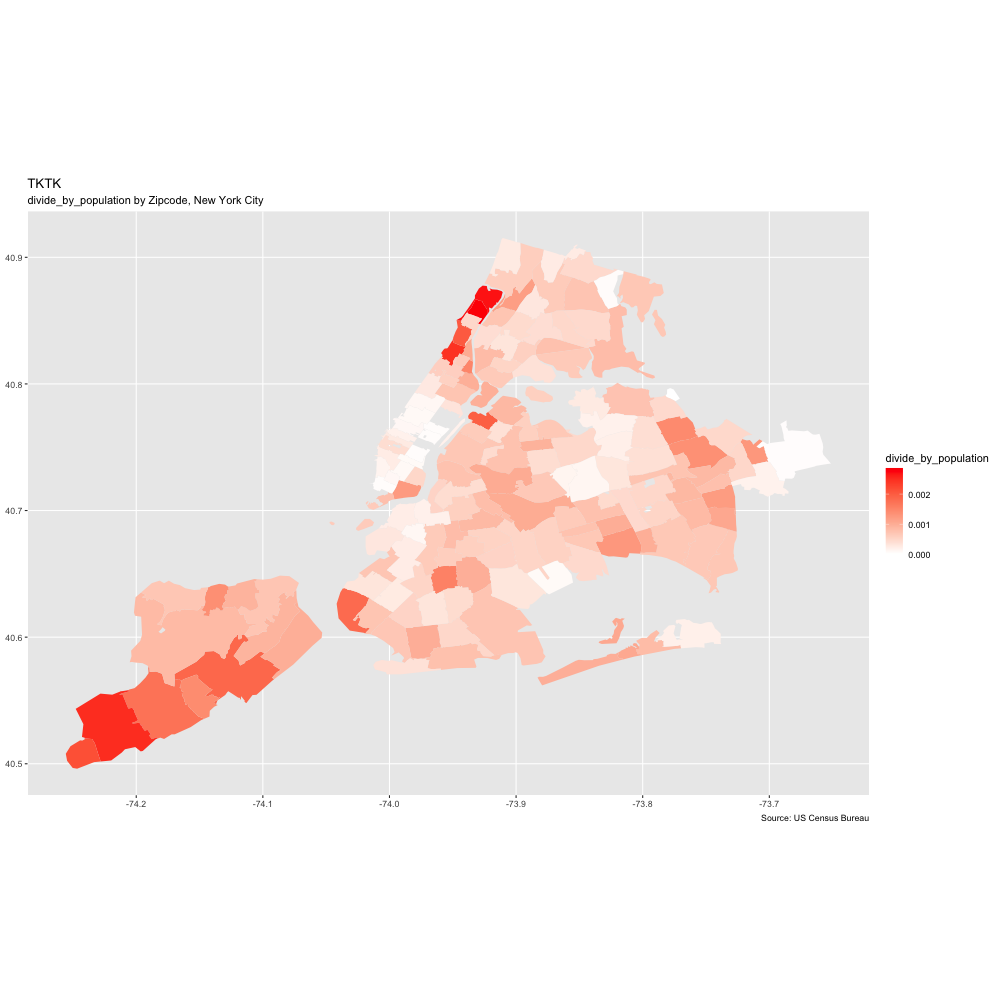

In [27]:
%%R -w 1000 -h 1000
# draw a map to show the divide_by_population by geometry
merged %>%
  ggplot(aes(fill = divide_by_population, geometry = geometry)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "divide_by_population by Zipcode, New York City",
    caption = "Source: US Census Bureau"
  )

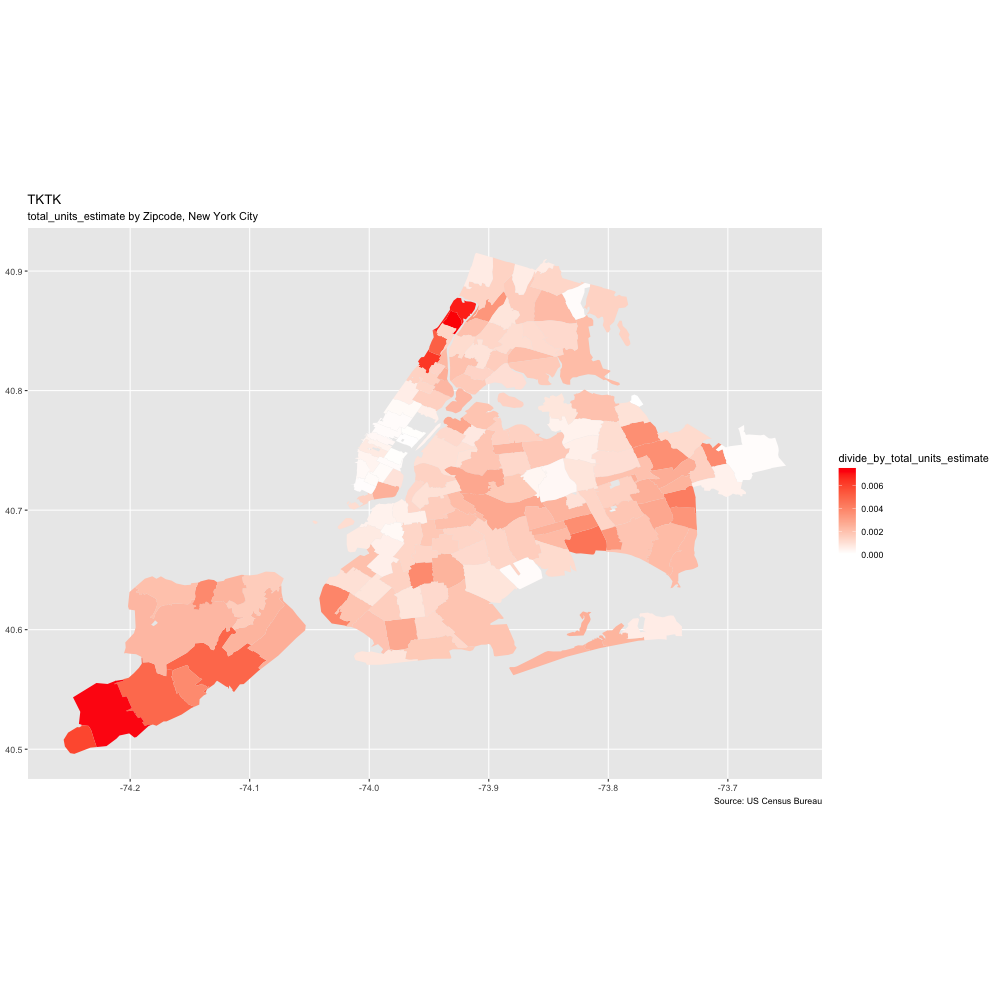

In [29]:
%%R -w 1000 -h 1000
# draw a map to show the divide_by_population by geometry
merged %>%
  ggplot(aes(fill = divide_by_total_units_estimate, geometry = geometry)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "total_units_estimate by Zipcode, New York City",
    caption = "Source: US Census Bureau"
  )